# Autoencoder for denoising on the CIFAR-10 dataset

# Importing the required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Loading the CIFAR-10 data

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 128


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


cifar_train = datasets.CIFAR10('data', train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10('data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(cifar_train))
val_size = len(cifar_train) - train_size

cifar_train, cifar_val = torch.utils.data.random_split(cifar_train, [train_size, val_size])


trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12378605.92it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Visualizing some images

In [4]:
def imshow(img):
  img = img / 2 + 0.5
  img = np.clip(img, 0, 1)
  plt.imshow(np.transpose(img, (1, 2, 0)))

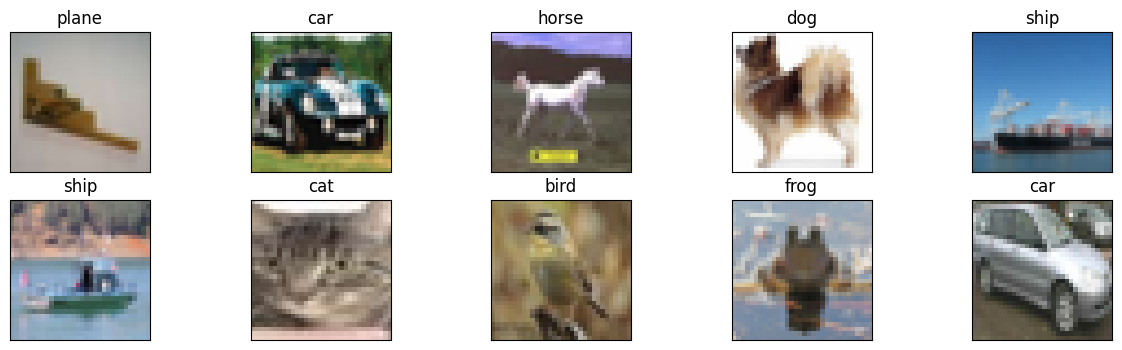

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(15, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

# Defining the model architecture and parameters


In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # 32 32 3
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # 32 32 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # 16 16 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        # 16 16 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 32 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),   # 32 32 3
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def initialize_weights(model):
    for _, layer in model.named_modules():
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = DenoisingAutoencoder()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
initialize_weights(model)

# Training the Model


In [7]:
train_losses = []
val_losses = []

for epoch in range(250):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        noise = torch.randn_like(inputs) * 0.4
        noisy_inputs = noise + inputs
        recon = model(noisy_inputs)
        loss = criterion(recon, inputs)
        train_loss += loss.item() * batch_size
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss / len(cifar_train))

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(validloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            noise = torch.randn_like(inputs) * 0.4
            noisy_inputs = noise + inputs
            recon = model(noisy_inputs)
            loss = criterion(recon, inputs)
            val_loss += criterion(recon, inputs).item() * batch_size

        val_losses.append(val_loss / len(cifar_val))

    if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch + 1} train_loss: {train_losses[epoch]:.4f} val_loss: {val_losses[epoch]:.4f}')

Epoch 5 train_loss: 0.1592 val_loss: 0.1528
Epoch 10 train_loss: 0.1043 val_loss: 0.1006
Epoch 15 train_loss: 0.0781 val_loss: 0.0765
Epoch 20 train_loss: 0.0644 val_loss: 0.0632
Epoch 25 train_loss: 0.0561 val_loss: 0.0553
Epoch 30 train_loss: 0.0507 val_loss: 0.0499
Epoch 35 train_loss: 0.0470 val_loss: 0.0465
Epoch 40 train_loss: 0.0442 val_loss: 0.0438
Epoch 45 train_loss: 0.0420 val_loss: 0.0416
Epoch 50 train_loss: 0.0404 val_loss: 0.0399
Epoch 55 train_loss: 0.0389 val_loss: 0.0383
Epoch 60 train_loss: 0.0377 val_loss: 0.0372
Epoch 65 train_loss: 0.0366 val_loss: 0.0363
Epoch 70 train_loss: 0.0358 val_loss: 0.0353
Epoch 75 train_loss: 0.0350 val_loss: 0.0346
Epoch 80 train_loss: 0.0344 val_loss: 0.0339
Epoch 85 train_loss: 0.0338 val_loss: 0.0332
Epoch 90 train_loss: 0.0331 val_loss: 0.0327
Epoch 95 train_loss: 0.0327 val_loss: 0.0322
Epoch 100 train_loss: 0.0323 val_loss: 0.0319
Epoch 105 train_loss: 0.0320 val_loss: 0.0314
Epoch 110 train_loss: 0.0315 val_loss: 0.0310
Epoch 11

# Plotting training statistics

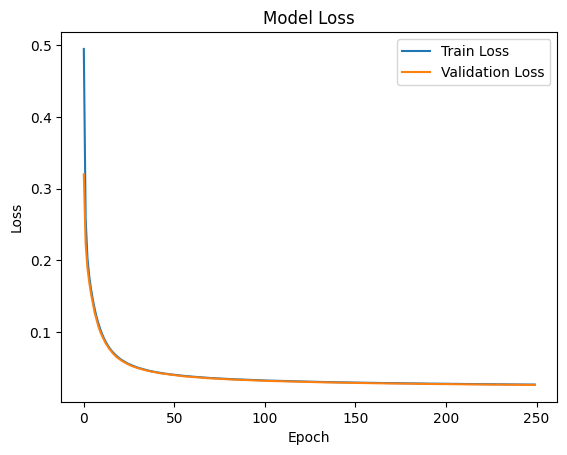

In [8]:
legend = ['Train Loss', 'Validation Loss']
plt.title('Model Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

# Testing the network


In [9]:
with torch.no_grad():
    test_loss = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        noise = torch.randn_like(inputs) * 0.4
        noisy_inputs = noise + inputs
        recon = model(noisy_inputs)
        loss = criterion(recon, inputs)
        test_loss += criterion(recon, inputs).item() * 128


print(f'Test Loss: {test_loss/len(cifar_test):.4f}')

Test Loss: 0.0260


# Visualizing the models outputs

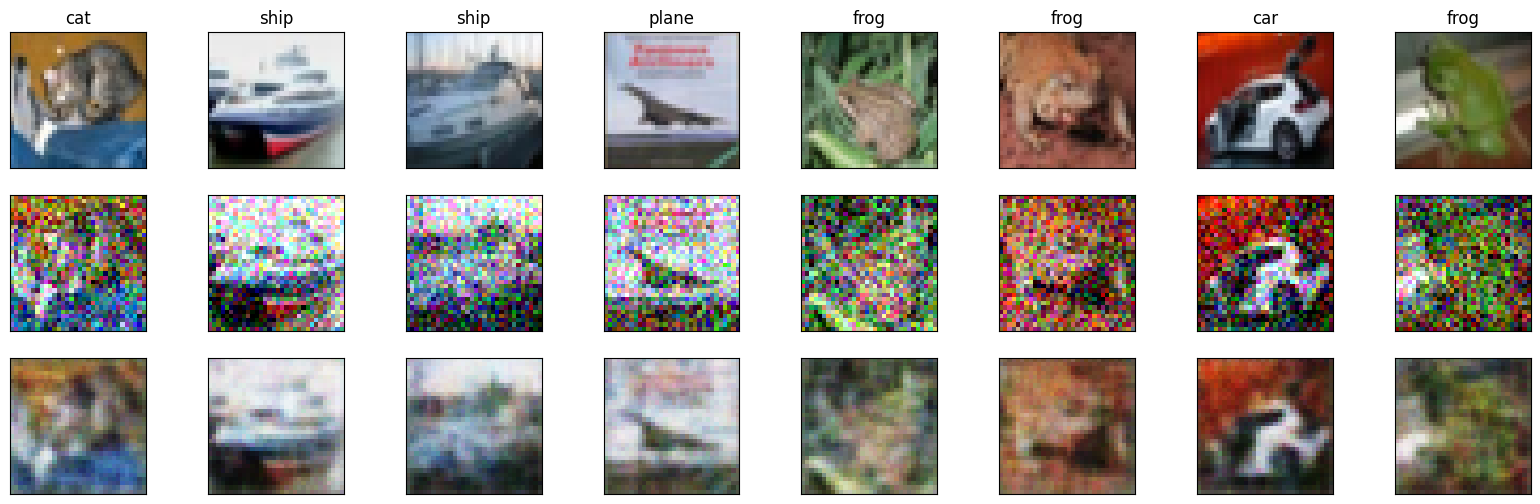

In [10]:
dataiter = iter(testloader)
inputs, labels = next(dataiter)
inputs = inputs.to(device)


with torch.no_grad():
  noise = torch.randn_like(inputs) * 0.4
  noisy_inputs = noise + inputs
  recon = model(noisy_inputs)

fig = plt.figure(figsize=(20, 6))
inputs = inputs.cpu().numpy()
noisy_inputs = noisy_inputs.cpu().numpy()
recon = recon.cpu().numpy()

for i in range(8):
    ax = fig.add_subplot(3, 8, i + 1, xticks=[], yticks=[])
    imshow(inputs[i])
    ax.set_title(classes[labels[i]])
    ax = fig.add_subplot(3, 8, i + 8 + 1, xticks=[], yticks=[])
    imshow(noisy_inputs[i])
    ax = fig.add_subplot(3, 8, i + 16 + 1, xticks=[], yticks=[])
    imshow(recon[i])